<a href="https://colab.research.google.com/github/kroppheather/utica_mapping/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [151]:
import keras
import tensorflow as tf

In [175]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

In [8]:
base_dir = Path('/content/drive/MyDrive/research/projects/utica')
mask_dir = base_dir.joinpath('mask')
train_image_dir = mask_dir.joinpath('u_train_reproject')
trees_mask_dir = mask_dir.joinpath('trees')
building_mask_dir = mask_dir.joinpath('building')
pavement_mask_dir = mask_dir.joinpath('pavement')

In [9]:
I, N, M = 20, 256, 256

In [10]:
os.listdir(mask_dir)

['trees', 'pavement', 'building', 'u_train_reproject']

In [21]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [12]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [13]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[6:-7,6:-6]

In [14]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [210]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [211]:
train_images = load_stack_safely((I, N, M), np.float32, train_image_dir, "wgs_train")
tree_masks = load_stack_safely((I, N, M), np.int8, trees_mask_dir, "tree_mask")
building_masks = load_stack_safely((I, N, M), np.int8, building_mask_dir, "building_mask")
pavement_masks = load_stack_safely((I, N, M), np.int8, pavement_mask_dir, "pavement_mask")

skipping /content/drive/MyDrive/research/projects/utica/mask/building/building_mask_8.tif
skipping /content/drive/MyDrive/research/projects/utica/mask/building/building_mask_19.tif
skipping /content/drive/MyDrive/research/projects/utica/mask/building/building_mask_8.tif
skipping /content/drive/MyDrive/research/projects/utica/mask/building/building_mask_19.tif
skipping /content/drive/MyDrive/research/projects/utica/mask/pavement/pavement_mask_19.tif
skipping /content/drive/MyDrive/research/projects/utica/mask/pavement/pavement_mask_19.tif


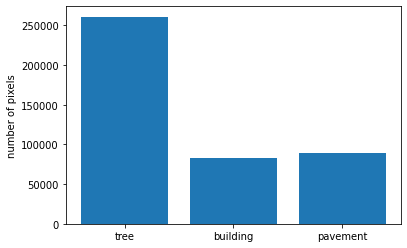

In [212]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

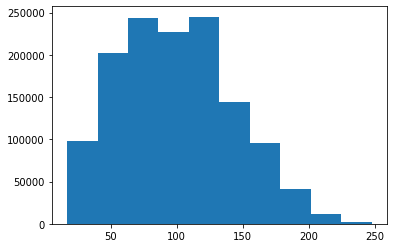

In [110]:
plt.hist(train_images.flatten())
plt.show()

In [213]:
model = satellite_unet(
    (N, M, 1),
    3,
    # dropout_type="spatial"
)

In [214]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [215]:
Y.shape, tree_masks.shape

((20, 256, 256, 3), (20, 256, 256))

In [216]:
Y = np.zeros(shape=(I, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [217]:
history = model.fit(
    train_images.reshape(I, N, M, 1),
    Y,
)

Train on 20 samples
20/20 [==============================] - 70s 4s/sample - loss: 0.8071 - iou: 0.0910 - iou_thresholded: 0.0814


In [218]:
Y_pred = model.predict(train_images.reshape(I, N, M, 1))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [219]:
Y_pred.shape, Y.shape

((20, 256, 256, 3), (20, 256, 256, 3))

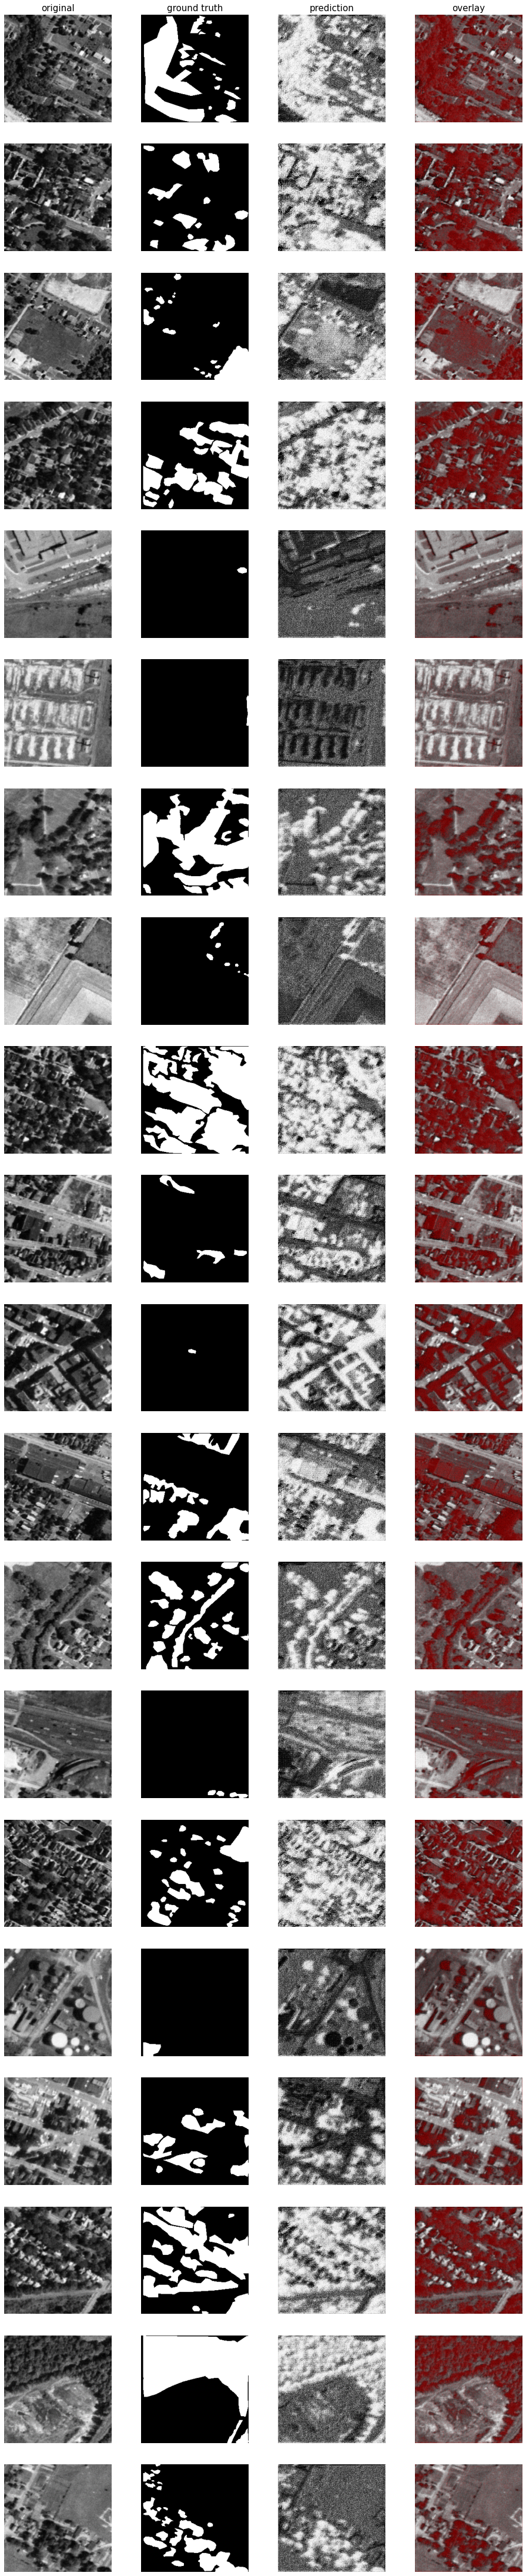

In [223]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=20
  )